In [1]:
import os
import cv2
import matplotlib.pyplot as plt

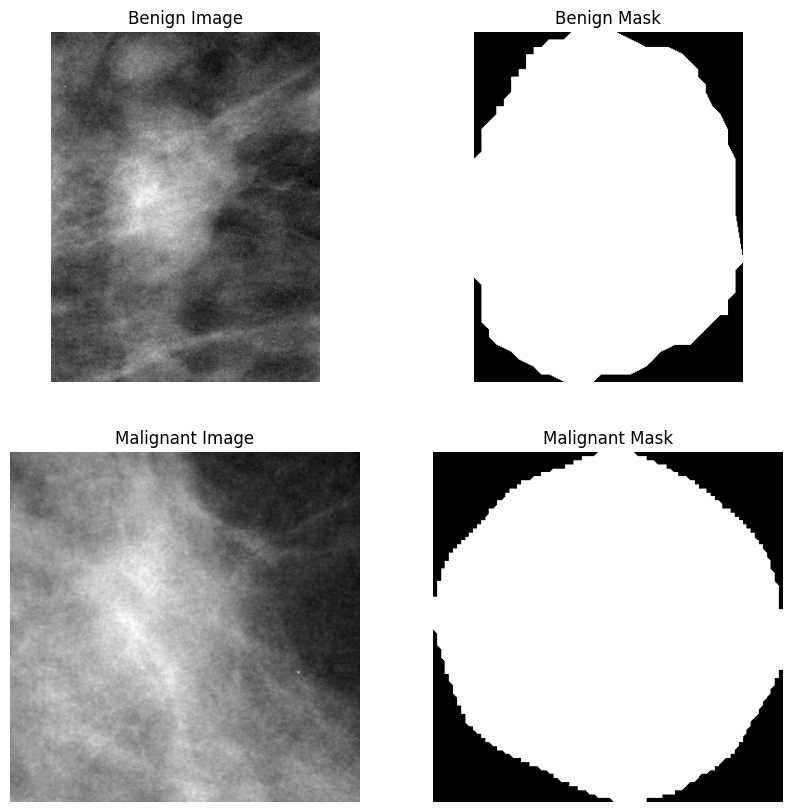

In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the data directory
data_dir = '/home/ubuntu/BTS/Breast_Cancer_Segmentation/Mass_Data'
categories = ['Benign', 'Malignant']

# Function to load and visualize data
def load_and_visualize_data(data_dir, categories):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    for i, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        images = [f for f in os.listdir(category_dir) if f.endswith('.png') and 'MASK' not in f]
        
        img_path = os.path.join(category_dir, images[0])
        mask_path = os.path.join(category_dir, images[0].replace('.png', '_MASK.png'))
        
        image = img_to_array(load_img(img_path, color_mode='grayscale'))
        mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
        
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'{category.capitalize()} Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{category.capitalize()} Mask')
        axes[i, 1].axis('off')
    
    plt.show()

# Visualize the data
load_and_visualize_data(data_dir, categories)


### Split the Data into Train, Validation, and Test Sets

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to get image and mask pairs
def get_image_mask_pairs(data_dir, categories):
    image_paths = []
    mask_paths = []
    
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        images = [f for f in os.listdir(category_dir) if f.endswith('.png') and 'MASK' not in f]
        
        for image in images:
            img_path = os.path.join(category_dir, image)
            mask_path = os.path.join(category_dir, image.replace('.png', '_MASK.png'))
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    return np.array(image_paths), np.array(mask_paths)

# Get image and mask pairs
image_paths, mask_paths = get_image_mask_pairs(data_dir, categories)

# Split the data
train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(train_img_paths, train_mask_paths, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Summary of the splits
print(f"Training set size: {len(train_img_paths)}")
print(f"Validation set size: {len(val_img_paths)}")
print(f"Test set size: {len(test_img_paths)}")


Training set size: 1176
Validation set size: 392
Test set size: 393


###  Augment the Data

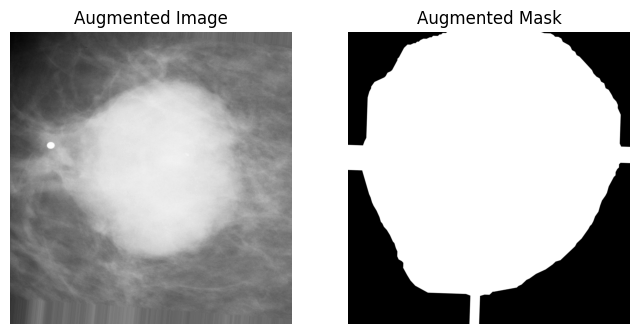

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Example of applying augmentation to an image and its mask
def augment_data(img_path, mask_path, image_datagen, mask_datagen):
    img = img_to_array(load_img(img_path, color_mode='grayscale'))
    mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
    
    img = img.reshape((1,) + img.shape)
    mask = mask.reshape((1,) + mask.shape)
    
    img_gen = image_datagen.flow(img, batch_size=1)
    mask_gen = mask_datagen.flow(mask, batch_size=1)
    
    img_aug, mask_aug = next(img_gen), next(mask_gen)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_aug[0].squeeze(), cmap='gray')
    axes[0].set_title('Augmented Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask_aug[0].squeeze(), cmap='gray')
    axes[1].set_title('Augmented Mask')
    axes[1].axis('off')
    
    plt.show()

# Example usage
augment_data(train_img_paths[0], train_mask_paths[0], image_datagen, mask_datagen)


### Design a U-Net Model

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Expanding Path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the model
model = unet_model()
model.summary()


2024-08-11 13:22:25.383874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-11 13:22:25.888487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-11 13:22:25.888753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Train the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create generators
def create_generators(image_paths, mask_paths, batch_size, image_datagen, mask_datagen):
    image_generator = image_datagen.flow_from_directory(
        image_paths,
        class_mode=None,
        color_mode='grayscale',
        batch_size=batch_size,
        target_size=(256, 256),
        seed=42
    )
    
    mask_generator = mask_datagen.flow_from_directory(
        mask_paths,
        class_mode=None,
        color_mode='grayscale',
        batch_size=batch_size,
        target_size=(256, 256),
        seed=42
    )
    
    return zip(image_generator, mask_generator)

# Generators for training and validation
train_generator = create_generators(train_img_paths, train_mask_paths, 16, image_datagen, mask_datagen)
val_generator = create_generators(val_img_paths, val_mask_paths, 16, image_datagen, mask_datagen)

# Callbacks
checkpoint = ModelCheckpoint('unet_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_img_paths) // 16,
    validation_data=val_generator,
    validation_steps=len(val_img_paths) // 16,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


### Visualize the Model Performance

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Visualize the performance
plot_training_history(history)


### Test the Model Performance on the Test Set

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model_on_test_set(model, test_img_paths, test_mask_paths):
    y_true = []
    y_pred = []
    
    for img_path, mask_path in zip(test_img_paths, test_mask_paths):
        img = img_to_array(load_img(img_path, color_mode='grayscale', target_size=(256, 256)))
        mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(256, 256)))
        
        img = img.reshape((1,) + img.shape)
        pred_mask = model.predict(img)
        pred_mask = (pred_mask > 0.5).astype(int)
        
        y_true.append(mask.flatten())
        y_pred.append(pred_mask.flatten())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
    print(f'Confusion Matrix:\n{conf_matrix}')

# Evaluate the model on the test set
evaluate_model_on_test_set(model, test_img_paths, test_mask_paths)
